In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy.stats import stats
from IPython.display import display
import pymc3 as pm
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
import arviz as az

%load_ext autoreload
%autoreload 2
%matplotlib inline

cwd = os.getcwd()

# Retrieve top 50 performing Bike ID

- result from earlier aggregation

In [2]:
# get the top 50 bike ids from the first dataset
bike_id_top_50 = pd.read_csv(os.path.join(
    cwd, "Citibike_Aggregate", "GroupBy_bikeid_Seconds_Distance.csv")).loc[:, "Bike ID"].values[:50]
bike_id_top_50

array([30503, 30875, 16777, 18504, 16533, 19957, 15336, 30446, 33252,
       27076, 18223, 25111, 27183, 21523, 27128, 24939, 17655, 31347,
       19422, 16355, 20999, 27556, 28721, 28287, 19903, 15356, 25220,
       17548, 17607, 18251, 15411, 25788, 26820, 31498, 31807, 27927,
       27452, 17546, 27789, 17094, 27578, 27808, 32036, 28340, 28653,
       15795, 20145, 28849, 26852, 31809], dtype=int64)

In [3]:
# get the data summarized
df = pd.read_csv(os.path.join(cwd, "Citibike_Aggregate",
                           "GroupBy_Year_Month_Day_Hour_top50_bikeid_Seconds_Distance.csv"))
df.head()

,Start Year,Start Month,Start Day,Start Hour,Bike ID,Duration_Seconds_SUM,Duration_Seconds_COUNT,Station_Distance_SUM,Station_Distance_COUNT
0,2017,1,1,0,15336,0,0,1,0
1,2017,1,1,0,15356,0,0,1,0
2,2017,1,1,0,15411,0,0,1,0
3,2017,1,1,0,15795,0,0,1,0
4,2017,1,1,0,16355,0,0,1,0


# Map the Duration of Bike Trips from the top 5 Bike IDs

- set upper limit to 30,000 due to outliers

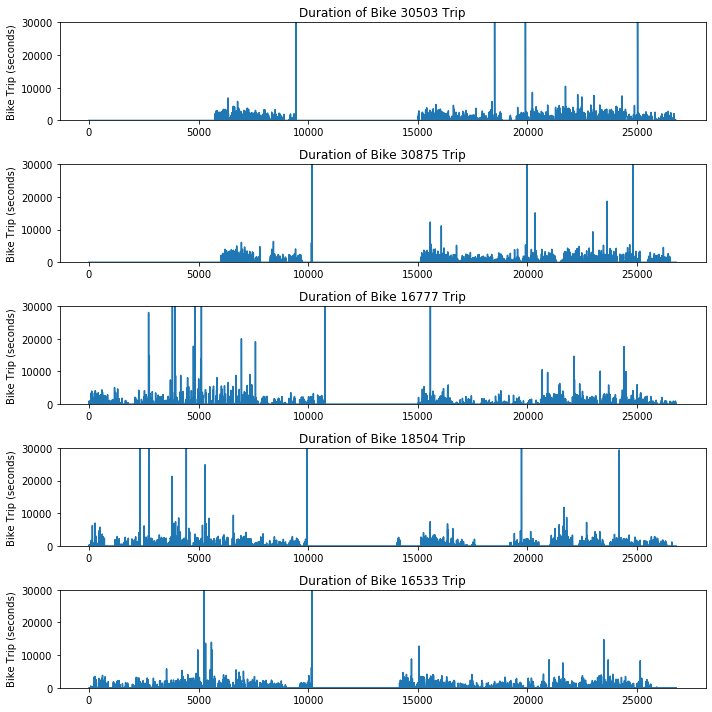

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,10))

for x in range(5):
    df_temp = df.loc[df["Bike ID"] == bike_id_top_50[x], "Duration_Seconds_SUM"].reset_index(drop=True)
    axes[x].plot(df_temp)
    axes[x].set_ylim(0, 30_000)
    axes[x].set_title(f"Duration of Bike {bike_id_top_50[x]} Trip")
    axes[x].set_ylabel("Bike Trip (seconds)")
    fig.tight_layout()
fig.savefig(os.path.join("images", "Top 5 CitiBike Bikes by IDs Durations.png"))

# Map the Distance between Stations of Bike Trips from the top 5 Bike IDs

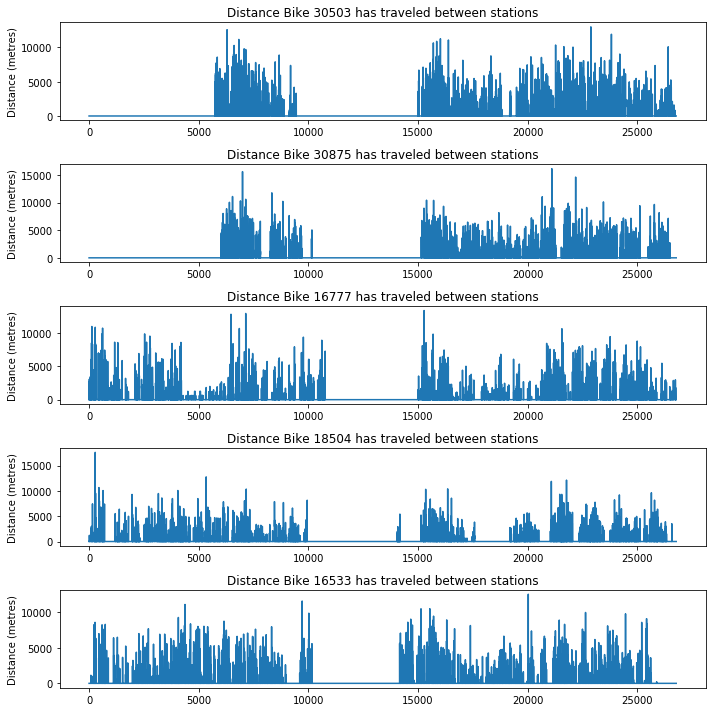

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,10))

for x in range(5):
    df_temp = df.loc[df["Bike ID"] == bike_id_top_50[x], "Station_Distance_SUM"].reset_index(drop=True)
    axes[x].plot(df_temp)
    axes[x].set_title(f"Distance Bike {bike_id_top_50[x]} has traveled between stations")
    axes[x].set_ylabel("Distance (metres)")
    fig.tight_layout()
fig.savefig(os.path.join("images", "Top 5 CitiBike Bikes by IDs Distance.png"))

# Model the number of trips in a 3 year period

- Binomial distribution

In [6]:
# take a slice of only 1 bike to make template pymc3 models for count, duration and distance
df_top_bike = df.loc[df["Bike ID"] == bike_id_top_50[0], :].reset_index(drop=True).copy()
df_top_bike.head()

,Start Year,Start Month,Start Day,Start Hour,Bike ID,Duration_Seconds_SUM,Duration_Seconds_COUNT,Station_Distance_SUM,Station_Distance_COUNT
0,2017,1,1,0,30503,0,0,1,0
1,2017,1,1,1,30503,0,0,1,0
2,2017,1,1,2,30503,0,0,1,0
3,2017,1,1,3,30503,0,0,1,0
4,2017,1,1,4,30503,0,0,1,0


In [7]:
returns = df_top_bike["Duration_Seconds_COUNT"].values
returns

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
with pm.Model() as prelim_count_model:
    # Prior
    p = pm.Uniform("p", lower=0, upper=1)   
    
    # likelihood
    likelihood = pm.Binomial("likelihood", n=len(returns),
                             p=p, observed=returns)
    
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(15_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [p]


Sampling 3 chains for 1_000 tune and 15_000 draw iterations (3_000 + 45_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [9]:
burned_trace.varnames

['p_interval__', 'p']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


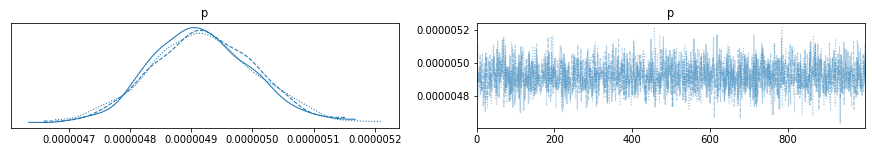

In [10]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for count for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


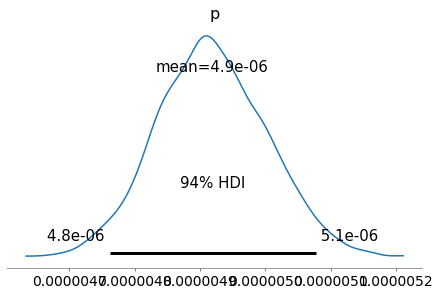

In [11]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for count for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


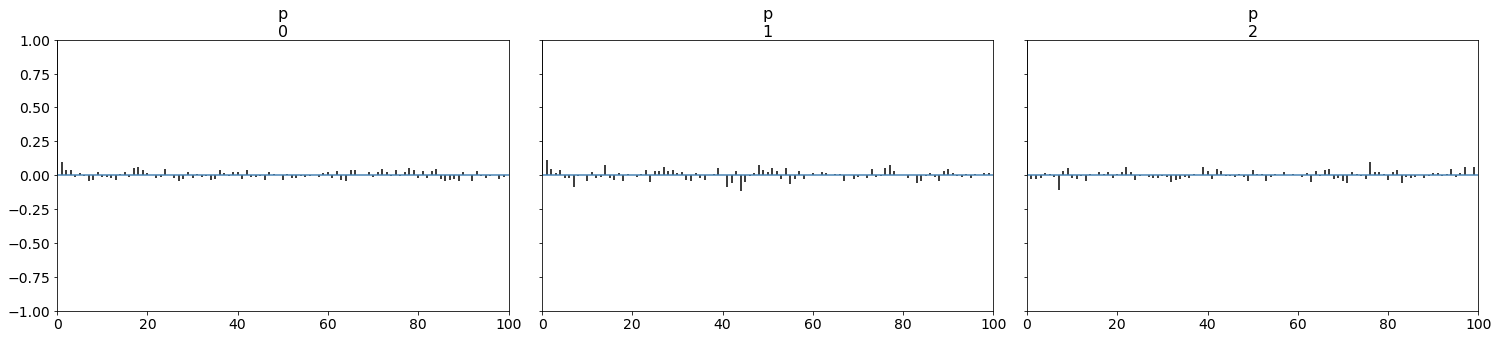

In [12]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for count for each hour-day-month-year.png"));

In [13]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.0,0.0,0.0,0.0,0.0,0.0,2479.0,2475.0,2492.0,2374.0,1.0


In [14]:
print(summary.to_markdown())

|    |   mean |   sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:---|-------:|-----:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| p  |      0 |    0 |        0 |         0 |           0 |         0 |       2479 |     2475 |       2492 |       2374 |       1 |


In [15]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

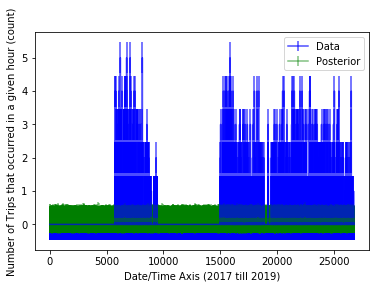

In [16]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for count for each hour-day-month-year.png"));

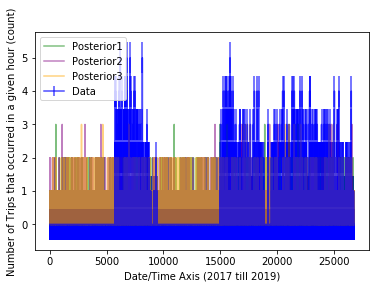

In [18]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for count for each hour-day-month-year.png"));

# Model the distance of trips in a 3 year period

- Exponential distribution

In [19]:
# returns is now going to be a percentage of the max
distance_max = df_top_bike["Station_Distance_SUM"].max()

returns = (df_top_bike["Station_Distance_SUM"] / distance_max).values
returns

array([7.68875903e-05, 7.68875903e-05, 7.68875903e-05, ...,
       7.68875903e-05, 7.68875903e-05, 7.68875903e-05])

In [20]:
with pm.Model() as prelim_distance_model:
    # Prior
    lam = pm.Uniform("lam", lower=1, upper=1000)
    
    # likelihood
    likelihood = pm.Exponential("likelihood", lam=lam,
                               observed=returns)
    
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [lam]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [21]:
burned_trace.varnames

['lam_interval__', 'lam']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


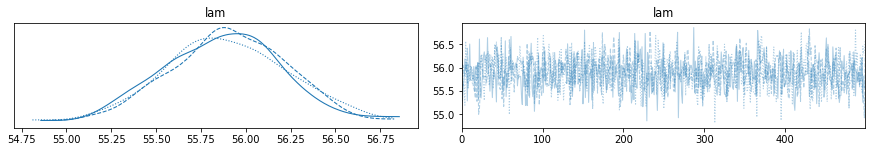

In [22]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for normalized distance for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


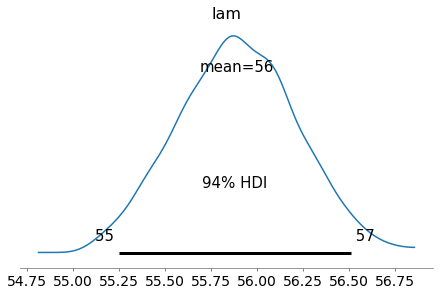

In [23]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for distance for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


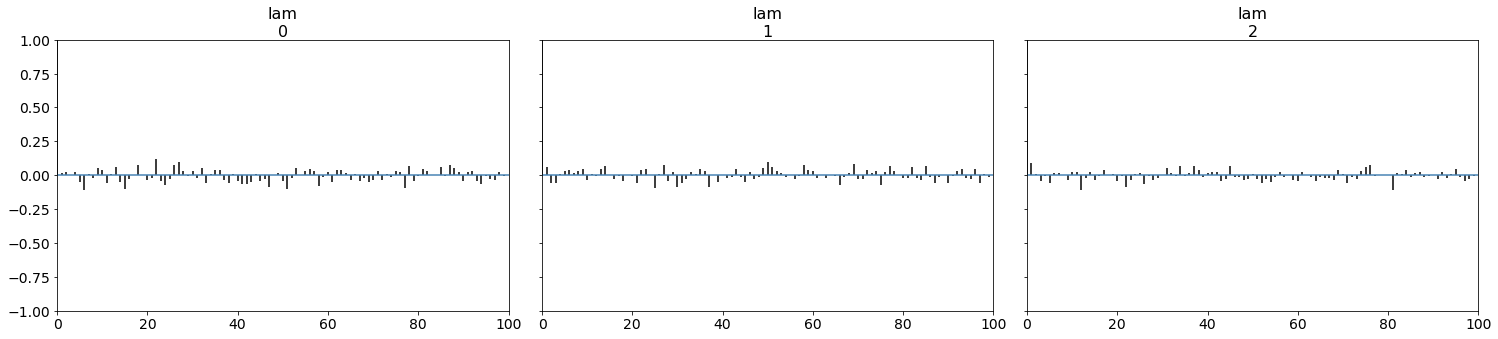

In [24]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for normalized distance for each hour-day-month-year.png"));

In [25]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam,55.889,0.337,55.249,56.511,0.009,0.007,1345.0,1345.0,1345.0,1363.0,1.0


In [26]:
print(summary.to_markdown())

|     |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| lam | 55.889 | 0.337 |   55.249 |    56.511 |       0.009 |     0.007 |       1345 |     1345 |       1345 |       1363 |       1 |


In [27]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

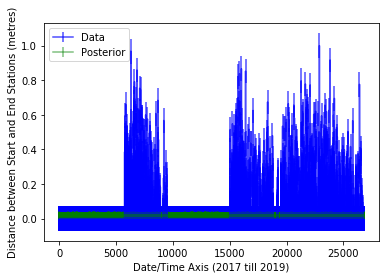

In [28]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Distance between Start and End Stations (metres)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for normalized distance for each hour-day-month-year.png"));

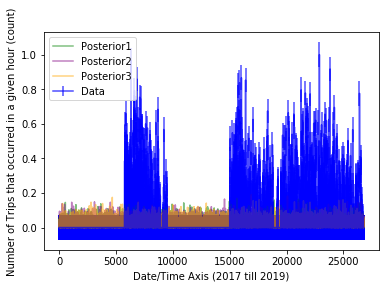

In [29]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for normalized distance for each hour-day-month-year.png"));

# Model the duration of trips in a 3 year period

- Exponential distribution

In [30]:
# anything in returns that is larger than 30,000 cap it there
df_top_bike.loc[df_top_bike["Duration_Seconds_SUM"] > 30_000, "Duration_Seconds_SUM"] = 30_000

# returns is now going to be a percentage of the max
duration_max = df_top_bike["Duration_Seconds_SUM"].max()

returns = (df_top_bike["Duration_Seconds_SUM"] / duration_max).values
returns

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
with pm.Model() as prelim_duration_model:
    # Prior
    lam = pm.Uniform("lam", lower=1, upper=1000)
    
    # likelihood
    likelihood = pm.Exponential("likelihood", lam=lam,
                               observed=returns)
    
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [lam]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 34 seconds.
The number of effective samples is smaller than 10% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [32]:
burned_trace.varnames

['lam_interval__', 'lam']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


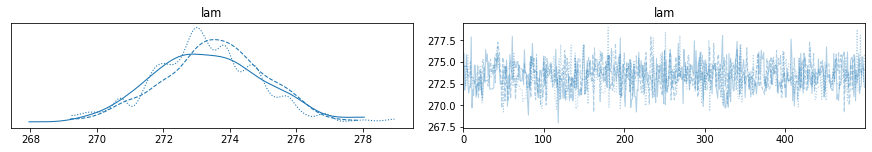

In [33]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for normalized duration for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


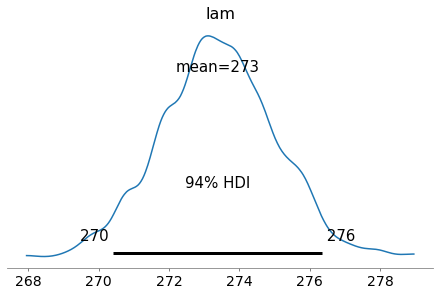

In [34]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for normalized duration for each hour-day-month-year.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


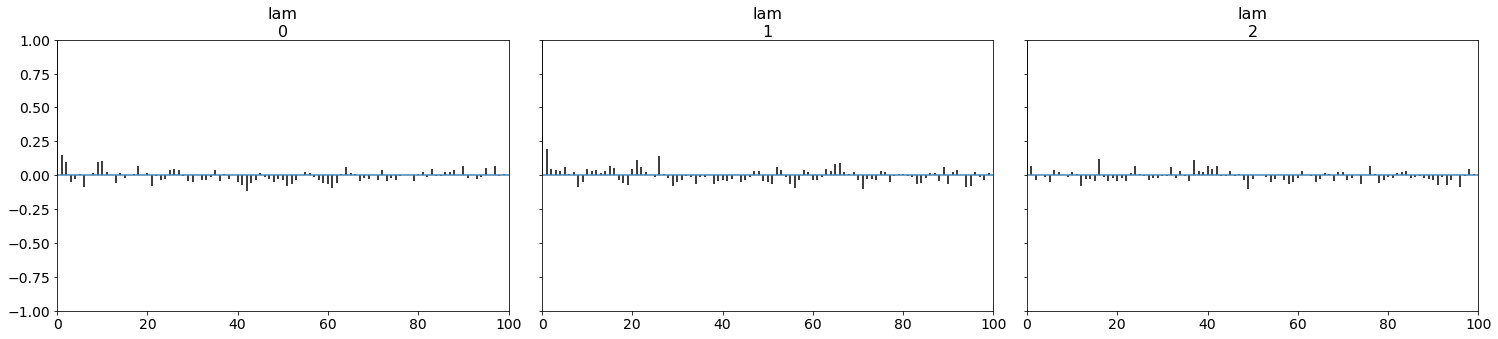

In [35]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for normalized duration for each hour-day-month-year.png"));

In [36]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam,273.391,1.615,270.417,276.342,0.049,0.035,1092.0,1092.0,1081.0,1153.0,1.0


In [37]:
print(summary.to_markdown())

|     |    mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:----|--------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| lam | 273.391 | 1.615 |  270.417 |   276.342 |       0.049 |     0.035 |       1092 |     1092 |       1081 |       1153 |       1 |


In [38]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

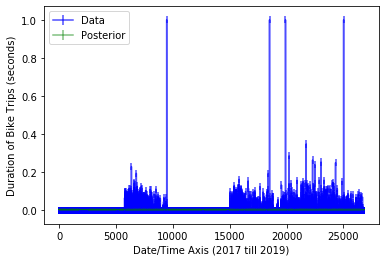

In [39]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Duration of Bike Trips (seconds)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for normalized duration for each hour-day-month-year.png"));

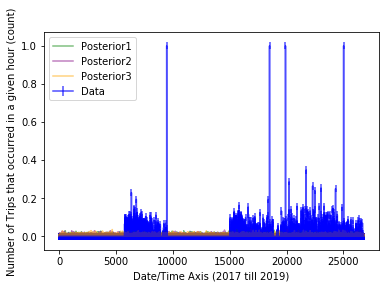

In [40]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for normalized duration for each hour-day-month-year.png"));